# Anime Recomendation Database 2020
# Recommender System

Descripión:

En esta notebook se entrena un modelo con LightFm para generar recomendaciones para todos los usuarios en base a los ratings de los anime. Además, se evaluá la precisión del mode![MAP hiperparametros.png](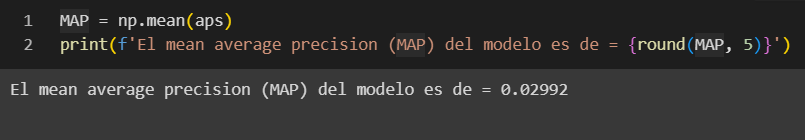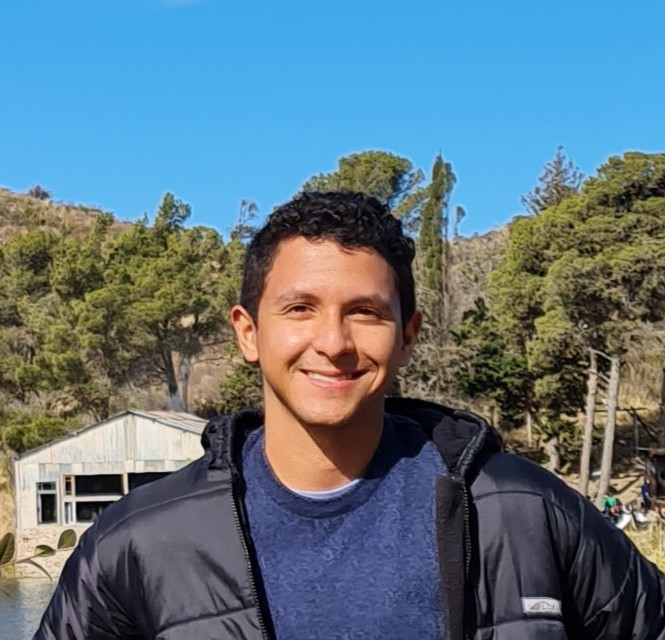)lo con las métricas "precision at k" y "MAP"

###Instalar e importar paquetes

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
pip install scikit-learn lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808331 sha256=130d9a6b2edfe61d184e550315853ae802b62d1b79e03a229a9cd4994a7d9692
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [3]:
from lightfm import LightFM

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from lightfm.evaluation import precision_at_k

In [6]:
from lightfm.data import Dataset

###Montar google drive e importar dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importamos el archivo con los ratings filtrados como producto del EDA

In [14]:
path="/content/rating_complete_filtrado.csv"
df=pd.read_csv(path)
df = df.drop(columns='Unnamed: 0', axis = 0)
print(df.shape)
df.head(2)

(46586264, 3)


,user_id,anime_id,rating
0,3,25835,8
1,3,28171,8


Importamos el archivo con la sypnopsis de los anime

In [9]:
path_anime="/content/synopsis.csv"
anime_data=pd.read_csv(path_anime)
print(anime_data.shape)
anime_data.head(2)

(16214, 3)


,MAL_ID,Name,sypnopsis
0,1,Cowboy Bebop,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"other day, another bounty—such is the life of ..."


###Split train y test segun userID

In [15]:
train, test = train_test_split(df, test_size=0.30, random_state=0)

In [16]:
print(train.shape,'Tamaño conjunto train');\
print(test.shape,'Tamaño conjunto test')

(32610384, 3) Tamaño conjunto train
(13975880, 3) Tamaño conjunto test


In [17]:
test[~test.user_id.isin(train.user_id.unique())].user_id.nunique()

0

In [18]:
train.sample(5)

,user_id,anime_id,rating
29132578,221362,1137,7
8672414,65598,4177,8
439073,3602,8769,4
33250870,252582,33486,9
40349392,305920,38333,8


###Generacion o importación de matriz de interacción para train y test

Aquí se filtran solo los animes y los users que están en train y test

In [19]:
test_data_filtered = test[test['anime_id'].isin(train['anime_id']) & test['user_id'].isin(train['user_id'])]

In [20]:
dataset = Dataset()

Fit del dataset con los datos de entrenamiento

In [21]:
dataset.fit(train['user_id'], train['anime_id'])

**Importamos las matrices de interacción para train y test desde un objeto pickle**

In [24]:
path_matriz_train = '/content/matriz_interacciones.pickle'
path_matriz_test = '/content/matriz_interacciones_test.pickle'

In [25]:
with open(path_matriz_train, 'rb') as f:
    interactions_train = pickle.load(f)

In [26]:
with open(path_matriz_test, 'rb') as f:
    interactions_test = pickle.load(f)

In [ ]:
#Ejecutar esta celda solo si no ha importado las matrices de interacciones para entrenamiento
%%time
(interactions_train, _) = dataset.build_interactions([(x['user_id'], x['anime_id'], x['rating']) for index, x in train.iterrows()])

CPU times: user 24min 53s, sys: 7.3 s, total: 25min
Wall time: 25min 11s


In [ ]:
#Ejecutar esta celda solo si no ha importado las matrices de interacciones para test
%%time
(interactions_test, _) = dataset.build_interactions([(x['user_id'], x['anime_id'], x['rating']) for index, x in test_data_filtered.iterrows()])

CPU times: user 10min 36s, sys: 2.04 s, total: 10min 38s
Wall time: 10min 46s


###Cold start: obtención de animes populares

In [27]:
train.groupby("anime_id", as_index=False).agg({"user_id":"nunique"})

,anime_id,user_id
0,1,35620
1,5,16785
2,6,22895
3,7,5431
4,8,900
...,...,...
16821,47614,37
16822,47616,931
16823,47618,14
16824,48177,26


In [28]:
popularity_df = train.groupby("anime_id", as_index=False).agg({"user_id":"nunique"}).sort_values(by="user_id", ascending=False)
popularity_df.columns=["anime_id", "popularity"]

In [29]:
popularity_df.head(3)

,anime_id,popularity
7436,16498,68332
6603,11757,67025
1390,1535,66398


In [30]:
popular_content = popularity_df.anime_id.values[:20]
popularity_df.head(20).anime_id.values

array([16498, 11757,  1535,  6547, 30276,  4224, 19815,  1575,  5114,
        9253, 22319, 31964,  2904, 20507, 10620, 32281,  8074,   199,
       15809,  9989])

###Diccionario para user_id e item_id

In [31]:
user_id_list = list(dataset.mapping()[0])
user_dict = {}
counter = 0
for i in user_id_list:
    user_dict[i] = counter
    counter += 1

In [32]:
item_id_list = list(dataset.mapping()[2])
item_dict = {}
counter = 0
for i in item_id_list:
    item_dict[i] = counter
    counter += 1

###Hiperparámetros del modelo y fiteado con matriz de entrenamiento

In [33]:
model = LightFM(loss='warp')

In [34]:
%%time
model.fit(interactions_train, epochs=20, verbose = True)

Epoch: 100%|██████████| 20/20 [25:24<00:00, 76.21s/it]

CPU times: user 25min 14s, sys: 4.37 s, total: 25min 19s
Wall time: 25min 24s


Prueba de predicción del modelo con un userid

In [35]:
user_id = 150
all_anime = np.unique(interactions_train.nonzero()[1])
recommendations = model.predict(user_id, all_anime)
top_anime = np.argsort(-recommendations)
n_recommendations = 30
recommended_anime_ids = all_anime[top_anime[:n_recommendations]]
print("Recomendaciones de anime_id para el usuario", user_id, ":", recommended_anime_ids)

Recomendaciones de anime_id para el usuario 150 : [ 240  824  784   32 1639  849  728  217  350 1836  193  207    3  309
  803   46  667  551  166   49  377  602  285  268 1594  711   36   92
  394   43]


###Obtenemos las recomendaciones para todos los usuarios

In [36]:
from tqdm import tqdm

#definimos dict donde vamos a ir almacenando las recomendaciones
recomms_dict = {
    'user_id': [],
    'recomms': [],
    'cold': []
}

#obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = interactions_train.shape
item_ids = np.arange(n_items)

#por cada usuario del dataset de test, generamos recomendaciones
for user in tqdm(test.user_id.unique()):
    #COMPLETAR: Validar si el usuario se encuentra en la matriz de interacciones de train
    if user in list(user_id_list):
      # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
      user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)

      #COMPLETAR: Generar las predicciones para el usuario x
      preds = model.predict(user_ids=user_x, item_ids = item_ids)

      #COMPLETAR: Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
      scores = pd.Series(preds)
      scores.index = item_id_list
      scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]

      #COMPLETAR: Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
      watched_contents = train[train.user_id == user].anime_id.unique()

      #COMPLETAR: Filtrar contenidos ya vistos y quedarse con los primeros 20
      recomms = [x for x in scores if x not in watched_contents][:20]

      # Guardamos las recomendaciones en el diccionario
      recomms_dict['user_id'].append(user)
      recomms_dict['recomms'].append(scores)
      recomms_dict["cold"].append(False)

    # En este else trataremos a los usuarios que no están en la matriz (cold start)
    else:
      recomms_dict['user_id'].append(user)
      # Les recomendamos contenido popular
      recomms_dict['recomms'].append(popular_content)
      recomms_dict["cold"].append(True)



100%|██████████| 125566/125566 [2:44:14<00:00, 12.74it/s]


###Generar dataframe con todas las recomendaciones por usuarios

In [37]:
recomms_df = pd.DataFrame(recomms_dict)
print(recomms_df.shape)
recomms_df.head(3)

(125566, 3)


,user_id,recomms,cold
0,339268,"[1575, 226, 1535, 2904, 11757, 8074, 16498, 65...",False
1,187291,"[25777, 31964, 32281, 33486, 30276, 16498, 117...",False
2,43205,"[6213, 14813, 8937, 4654, 10521, 14741, 849, 2...",False


Exportamos el dataframe de recomendaciones como archivo csv para usarlo más adelante

In [38]:
recomms_df.to_csv('/content/Recomendaciones.csv')

In [39]:
with open('recomendaciones.pickle', 'wb') as f:
    pickle.dump(recomms_df, f)

###Evaluación del modelo

Calculamos la métrica precision at k de la librería lightfm

In [40]:
precision_at_k(model, interactions_test, k= 20).mean()

0.25294906

Importamos el csv o el objeto picklet con todas las recomedaciones para todos los usuarios

In [ ]:
path_recomms_df = "/content/recomendaciones.pickle"
with open(path_recomms_df, 'rb') as f:
    recomms_df = pickle.load(f)

In [41]:
#recomms_df= recomms_df.drop(columns='Unnamed: 0')
recomms_df.head()

,user_id,recomms,cold
0,339268,"[1575, 226, 1535, 2904, 11757, 8074, 16498, 65...",False
1,187291,"[25777, 31964, 32281, 33486, 30276, 16498, 117...",False
2,43205,"[6213, 14813, 8937, 4654, 10521, 14741, 849, 2...",False
3,107483,"[19163, 15451, 15583, 9181, 13663, 23233, 2470...",False
4,280262,"[22319, 30276, 27899, 16498, 22535, 23755, 302...",False


Generamos un dataframe con las recomendaciones "ideales" para cada usuario en test.

In [42]:
ideal_recomms = test.sort_values(by=["user_id", "rating"], ascending=False)\
                  .groupby(["user_id"], as_index=False)\
                  .agg({"anime_id": "unique"})
ideal_recomms.head(2)

,user_id,anime_id
0,3,"[2251, 47, 6675, 36296, 19363, 226, 35968, 136..."
1,6,"[849, 9756, 2001, 4814, 1205, 5114, 6547, 416,..."


Generamos un nuevo dataframe donde estén los id de usuarios junto a la recomendación ideal y a la recomendación predicha por el modelo.

In [43]:
df_map = ideal_recomms.merge(recomms_df, how="left", left_on="user_id", right_on="user_id")[["user_id", "anime_id", "recomms"]]
df_map.columns = ["user_id", "ideal", "recomms"]
df_map.head(2)

,user_id,ideal,recomms
0,3,"[2251, 47, 6675, 36296, 19363, 226, 35968, 136...","[10719, 14813, 14741, 15809, 5081, 13759, 8769..."
1,6,"[849, 9756, 2001, 4814, 1205, 5114, 6547, 416,...","[7059, 1004, 4472, 1887, 528, 9756, 317, 1117,..."


Calculamos el average precision para cada usuario

In [44]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación

for pred, label in df_map[["ideal", "recomms"]].values:
  n = len(pred) # cantidad de elementos recomendados
  arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1
  rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
  tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
  denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
  ap = (tp / denom).sum() / len(label) # average precision
  aps.append(ap)


Finalmente calculamos el mean average precision

In [45]:
MAP = np.mean(aps)
print(f'El mean average precision (MAP) del modelo es de = {round(MAP, 5)}')

El mean average precision (MAP) del modelo es de = 0.06158


###Obtener la predicción para un usuario específico

In [46]:
def get_recommendations(user_id, recomms_df=recomms_df, anime_data=anime_data):
    user_recommendations = recomms_df[recomms_df['user_id'] == user_id]['recomms'].values[0]

    anime_names = anime_data.set_index('MAL_ID')['Name']

    recommendations_list = []
    for anime_id in user_recommendations:
        anime_name = anime_names.get(anime_id)
        if anime_name:
            recommendations_list.append({'anime_id': anime_id, 'anime_name': anime_name})
        else:
            recommendations_list.append({'anime_id': anime_id, 'anime_name': 'Not Found'})

    return pd.DataFrame(recommendations_list).head(20)

Modificar la variable user por el usuario que se desea consultar

In [47]:
user = 6
print(f'Recomendations for user {user}')
get_recommendations(user)

Recomendations for user 6


,anime_id,anime_name
0,7059,Black★Rock Shooter (OVA)
1,1004,Kanojo to Kanojo no Neko
2,4472,Lucky☆Star: Original na Visual to Animation
3,1887,Lucky☆Star
4,528,Pokemon Movie 01: Mewtwo no Gyakushuu
5,9756,Mahou Shoujo Madoka★Magica
6,317,Final Fantasy VII: Advent Children
7,1117,Pokemon Movie 02: Maboroshi no Pokemon Lugia B...
8,849,Suzumiya Haruhi no Yuuutsu
9,1118,Pokemon Movie 03: Kesshoutou no Teiou Entei


### Evaluación del modelo entrenado con parámetros obtenido en el GridSearch

**Los parámetros obtenidos en GridSearch fueron:**

Learning rate : 0.009

Loss: logistic

N° components: 1

El precision at k del modelo es de = 0.17258295

El mean average precision (MAP) del modelo es de = 0.02992